## Assignment 1 - Environment

Zlata Izvalava

In [14]:
import random
import copy

In [15]:
import enum


class Orientation(enum.Enum):
    north = 1
    east = 2
    south = 3
    west = 4
    
    
    @property
    def turn_left(self):
        dict_turn_left = {
            Orientation.north: Orientation.west, 
            Orientation.south: Orientation.east, 
            Orientation.east: Orientation.north, 
            Orientation.west: Orientation.south
        }
        new_orientation = dict_turn_left.get(self)
        return new_orientation
    
    
    @property
    def turn_right(self):
        dict_turn_right = {
            Orientation.north: Orientation.east, 
            Orientation.south: Orientation.west, 
            Orientation.east: Orientation.south, 
            Orientation.west: Orientation.north
        }
        new_orientation = dict_turn_right.get(self)
        return new_orientation

In [16]:
class Action():
    def __init__(self, is_forward=False, is_turn_left=False, is_turn_right=False, 
                 is_shoot=False, is_grab=False, is_climb=False):
        assert is_forward ^ is_turn_left ^ is_turn_right ^ is_shoot ^ is_grab ^ is_climb
        self.is_forward = is_forward
        self.is_turn_left = is_turn_left
        self.is_turn_right = is_turn_right
        self.is_shoot = is_shoot
        self.is_grab = is_grab
        self.is_climb = is_climb
    
    @classmethod
    def forward(cls):
        return Action(is_forward=True)
    
    @classmethod
    def turn_left(cls):
        return Action(is_turn_left=True)
    
    @classmethod
    def turn_right(cls):
        return Action(is_turn_right=True)
    
    @classmethod
    def shoot(cls):
        return Action(is_shoot=True)
    
    @classmethod
    def grab(cls):
        return Action(is_grab=True)
    
    @classmethod
    def climb(cls):
        return Action(is_climb=True)
    
    def show(self):
        if self.is_forward:
            action_str = "Action: forward"
        elif self.is_turn_left:
            action_str = "Action: turn_left"
        elif self.is_turn_right:
            action_str = "Action: turn_right"
        elif self.is_shoot:
            action_str = "Action: shoot"
        elif self.is_grab:
            action_str = "Action: grab"
        else:
            action_str = "Action: climb"
        print(action_str)

In [17]:
from collections import namedtuple

class Coords(namedtuple('Coords', 'x y')):
    pass

In [18]:
class Percept():
    def __init__(self, stench, breeze, glitter, bump, scream, is_terminated, reward):
        self.stench = stench
        self.breeze = breeze
        self.glitter = glitter
        self.bump = bump
        self.scream = scream
        self.is_terminated = is_terminated
        self.reward = reward
    
    def show(self):
        print("stench: {}, breeze: {}, glitter: {}, bump: {}, scream: {}, is_terminated: {}, reward: {}"
              .format(self.stench, self.breeze, self.glitter, self.bump, self.scream, self.is_terminated, self.reward))

In [19]:
# Create locations for gold and wumpus
def random_location_except_origin(grid_width, grid_height):
    locations = []
    for col in range(grid_width):
        for row in range(grid_height):
            cell = Coords(x=col, y=row)
            locations.append(cell)
    locations.remove(Coords(0, 0))
    return random.choice(locations)


# Create pit locations
def create_pit_locations(grid_width, grid_height, pit_prob):
    locations = []
    pit_locations = []
    for col in range(grid_width):
        for row in range(grid_height):
            cell = Coords(x=col, y=row)
            locations.append(cell)
    locations.remove(Coords(0, 0))
    for loc in locations:
        if random.random() < pit_prob:
            pit_locations.append(loc)
    return pit_locations

In [20]:
class AgentState():
    def __init__(self, location=Coords(0, 0), orientation=Orientation.east, has_gold=False, has_arrow=True, is_alive=True):
        self.location = location
        self.orientation = orientation
        self.has_gold = has_gold
        self.has_arrow = has_arrow
        self.is_alive = is_alive
    
    def turn_left(self):
        new_state = copy.deepcopy(self)
        new_state.orientation = new_state.orientation.turn_left
        return new_state
    
    def turn_right(self):
        new_state = copy.deepcopy(self)
        new_state.orientation = new_state.orientation.turn_right
        return new_state
    
    def forward(self, grid_width, grid_height):
        if self.orientation == Orientation.north:
            new_loc = Coords(self.location.x, min(grid_height - 1, self.location.y + 1))
        elif self.orientation == Orientation.south:
            new_loc = Coords(self.location.x, max(0, self.location.y - 1))
        elif self.orientation == Orientation.east:
            new_loc = Coords(min(grid_width - 1, self.location.x + 1), self.location.y)
        else:
            new_loc = Coords(max(0, self.location.x - 1), self.location.y) # if Orientation.west
        new_state = copy.deepcopy(self)
        new_state.location = new_loc
        return new_state
    
    def is_at_home(self):
        return self.location.x == 0 and self.location.y == 0

In [21]:
class Environment():
    def __init__(self, grid_width, grid_height, pit_prob, allow_climb_without_gold, agent, pit_locations,
                 terminated, wumpus_loc, wumpus_alive, gold_loc):
        self.grid_width = grid_width
        self.grid_height = grid_height
        self.pit_prob = pit_prob
        self.allow_climb_without_gold = allow_climb_without_gold
        self.agent = agent
        self.pit_locations = pit_locations
        self.terminated = terminated
        self.wumpus_loc = wumpus_loc
        self.wumpus_alive = wumpus_alive
        self.gold_loc = gold_loc
    
    def is_pit_at(self, coords):
        return coords in self.pit_locations
    
    def is_wumpus_at(self, coords):
        return coords == self.wumpus_loc
    
    def is_agent_at(self, coords):
        return coords == self.agent.location
    
    def is_glitter(self):
        return self.gold_loc == self.agent.location
    
    def is_gold_at(self, coords):
        return coords == self.gold_loc
    
    def wumpus_in_line_of_fire(self):
        if self.agent.orientation == Orientation.west:
            return self.agent.location.x > self.wumpus_loc.x and self.agent.location.y == self.wumpus_loc.y
        if self.agent.orientation == Orientation.east:
            return self.agent.location.x < self.wumpus_loc.x and self.agent.location.y == self.wumpus_loc.y
        if self.agent.orientation == Orientation.south:
            return self.agent.location.x == self.wumpus_loc.x and self.agent.location.y > self.wumpus_loc.y
        if self.agent.orientation == Orientation.north:
            return self.agent.location.x == self.wumpus_loc.x and self.agent.location.y < self.wumpus_loc.y
    
    def kill_attempt_successful(self):
        return self.agent.has_arrow and self.wumpus_alive and self.wumpus_in_line_of_fire()
    
    def adjacent_cells(self, coords=Coords(0, 0)):
        return [
            Coords(coords.x - 1, coords.y) if coords.x > 0 else None, # to the left
            Coords(coords.x + 1, coords.y) if coords.x < (self.grid_width - 1) else None,  # to the right
            Coords(coords.x, coords.y - 1) if coords.y > 0 else None, # below
            Coords(coords.x, coords.y + 1) if coords.y < (self.grid_height - 1) else None, # above
        ]
    
    def is_pit_adjacent(self, coords):
        for cell in self.adjacent_cells(coords):
            if cell is None:
                continue
            if cell in self.pit_locations:
                return True
        return False
    
    def is_wumpus_adjacent(self, coords):
        for cell in self.adjacent_cells(coords):
            if cell is None:
                continue
            if self.is_wumpus_at(cell):
                return True
        return False
    
    def is_breeze(self):
        return self.is_pit_adjacent(self.agent.location)
    
    def is_stench(self):
        return self.is_wumpus_adjacent(self.agent.location) or self.is_wumpus_at(self.agent.location)
    
    def apply_action(self, action):
        if self.terminated:
            return (self, Percept(False, False, False, False, False, True, 0))
        else:
            if action.is_forward:
                moved_agent = self.agent.forward(self.grid_width, self.grid_height)
                death = (self.is_wumpus_at(moved_agent.location) and self.wumpus_alive) or self.is_pit_at(moved_agent.location)
                new_agent = copy.deepcopy(moved_agent)
                new_agent.is_alive = not death
                new_gold_loc = new_agent.location if self.agent.has_gold else self.gold_loc
                new_env = Environment(self.grid_width, self.grid_height, self.pit_prob, self.allow_climb_without_gold, 
                                      new_agent, self.pit_locations, death, self.wumpus_loc, self.wumpus_alive, new_gold_loc)
                percept = Percept(new_env.is_stench(), new_env.is_breeze(), new_env.is_glitter(), 
                                  new_agent.location == self.agent.location, False, death, 
                                  -1 if new_agent.is_alive else -1001)
                return (new_env, percept)
            
            if action.is_turn_left:
                new_env = Environment(self.grid_width, self.grid_height, self.pit_prob, self.allow_climb_without_gold, 
                                      self.agent.turn_left(), self.pit_locations, self.terminated, self.wumpus_loc, 
                                      self.wumpus_alive, self.gold_loc)
                percept = Percept(self.is_stench(), self.is_breeze(), self.is_glitter(), False, False, False, -1)
                return (new_env, percept)
            
            if action.is_turn_right:
                new_env = Environment(self.grid_width, self.grid_height, self.pit_prob, self.allow_climb_without_gold, 
                                      self.agent.turn_right(), self.pit_locations, self.terminated, self.wumpus_loc, 
                                      self.wumpus_alive, self.gold_loc)
                percept = Percept(self.is_stench(), self.is_breeze(), self.is_glitter(), False, False, False, -1)
                return (new_env, percept)
            
            if action.is_grab:
                new_agent = copy.deepcopy(self.agent)
                new_agent.has_gold = self.is_glitter()
                new_gold_loc = new_agent.location if new_agent.has_gold else self.gold_loc
                new_env = Environment(self.grid_width, self.grid_height, self.pit_prob, self.allow_climb_without_gold, 
                                      new_agent, self.pit_locations, self.terminated, self.wumpus_loc, self.wumpus_alive, 
                                      new_gold_loc)
                percept = Percept(self.is_stench(), self.is_breeze(), self.is_glitter(), False, False, False, -1)
                return (new_env, percept)
            
            if action.is_climb:
                in_start_loc = self.agent.location == Coords(0, 0)
                success = self.agent.has_gold and in_start_loc
                is_terminated = success or (self.allow_climb_without_gold and in_start_loc)
                new_env = Environment(self.grid_width, self.grid_height, self.pit_prob, self.allow_climb_without_gold, 
                                      self.agent, self.pit_locations, is_terminated, self.wumpus_loc, self.wumpus_alive, 
                                      self.gold_loc)
                percept = Percept(self.is_stench(), self.is_breeze(), self.is_glitter(), False, False, is_terminated, 
                                  999 if success else -1)
                return (new_env, percept)
            
            if action.is_shoot:
                had_arrow = self.agent.has_arrow
                wumpus_killed = self.kill_attempt_successful()
                new_agent = copy.deepcopy(self.agent)
                new_agent.has_arrow = False
                new_env = Environment(self.grid_width, self.grid_height, self.pit_prob, self.allow_climb_without_gold, 
                                      new_agent, self.pit_locations, self.terminated, self.wumpus_loc, 
                                      self.wumpus_alive and (not wumpus_killed), self.gold_loc)
                percept = Percept(self.is_stench(), self.is_breeze(), self.is_glitter(), False, wumpus_killed, False, 
                                  -11 if had_arrow else -1)
                return (new_env, percept)
    
    
    @classmethod
    def new_game(cls, grid_width, grid_height, pit_prob, allow_climb_without_gold):
        new_pit_locations = create_pit_locations(grid_width, grid_height, pit_prob)
        new_wumpus_loc = random_location_except_origin(grid_width, grid_height)
        new_gold_loc = random_location_except_origin(grid_width, grid_height)
        env = Environment(grid_width, grid_height, pit_prob, allow_climb_without_gold, 
                          AgentState(), new_pit_locations, False, new_wumpus_loc, True, new_gold_loc)
        percept = Percept(env.is_stench(), env.is_breeze(), False, False, False, False, 0.0)
        return (env, percept)
    
    
    def visualize(self):
        wumpus_symbol = "W" if self.wumpus_alive else "w"
        all_rows = []
        for y in range(self.grid_height - 1, -1, -1):
            row = []
            for x in range (self.grid_width):
                agent = "A" if self.is_agent_at(Coords(x, y)) else " "
                pit = "P" if self.is_pit_at(Coords(x, y)) else " "
                gold = "G" if self.is_gold_at(Coords(x, y)) else " "
                wumpus = wumpus_symbol if self.is_wumpus_at(Coords(x, y)) else " "
                cell = agent + pit + gold + wumpus
                row.append(cell)
            row_str = "|".join(row)
            all_rows.append(row_str)
        final_str = "\n".join(all_rows)
        print(final_str)
        print("Orientation: ", self.agent.orientation)

In [22]:
class Agent:
    def __init__(self):
        pass
    def update_state(self, new_state):
        pass
    
    def select_action(self, percept):
        raise NotImplementedError()

In [23]:
class NaiveAgent(Agent):
    def select_action(self, percept):
        actions = [Action.forward(), Action.turn_left(), Action.turn_right(), Action.shoot(), Action.grab(), Action.climb()]
        next_action = random.choice(actions)
        next_action.show() # print action
        return next_action

# Assignment 2
Sina Eizadshenass

In [24]:
import networkx as nx

class BeelineAgent(Agent):
    def __init__(self):
        self.path = nx.Graph()
        self.state = None
        self.gold_coords = None

    def select_action(self, percept):
        actions = [Action.forward(), Action.turn_left(), Action.turn_right(), Action.shoot()]
        
        if percept.glitter and not self.state.has_gold:
          next_action = Action.grab()
          self.gold_coords = self.state.location
        elif self.state.has_gold:
          if self.state.is_at_home():
            next_action = Action.climb()
          else:
            shortest_path_home = nx.shortest_path(self.path, source=self.state.location, target=Coords(x=0, y=0))
            next_step_towards_home = shortest_path_home[1] # we're always at least one step away from home since we're not home yet
            next_action = self.next_action_to_go_to(next_step_towards_home)
        else:
          next_action = random.choice(actions)
        
        next_action.show() # print action
        return next_action
    
    def next_action_to_go_to(self, next_location):
      desired_orientation = self.desired_orientation(next_location)
      # if facing the location go forward
      if self.state.orientation == desired_orientation:
        return Action.forward()
      # if not facing location then turn
      else:
        diff = desired_orientation.value - self.state.orientation.value
        #         1 -north  
        # west- 4 . 2 -east
        #         3 -south 
        if diff == -3 or diff == 1:
          return Action.turn_right()
        else:
          return Action.turn_left()
    
    def desired_orientation(self, next_location):
      # north if next_location.y = location.y + 1
      if next_location.y == self.state.location.y + 1:
        return Orientation.north
      elif next_location.y == self.state.location.y - 1:
        return Orientation.south
      elif next_location.x == self.state.location.x + 1:
        return Orientation.east
      elif next_location.x == self.state.location.x - 1:
        return Orientation.west
      else:
        raise Exception("Incorrect Next Step!")
      

    
    def update_state(self, new_state):
        self.path.add_node(new_state.location)
        if self.state != None and self.state.location != new_state.location:
          self.path.add_edge(self.state.location, new_state.location)
        self.state = new_state
    

    def draw_state(self):
        color_map = []
        for node in self.path:
            if node == Coords(x=0,y=0):
              color_map.append('green')
            elif node == self.gold_coords:
              color_map.append('yellow')
            else:
              color_map.append('lightgrey')
        nx.draw(self.path, with_labels=True, font_weight='bold', node_color=color_map)
        


In [25]:
def main():
    agent = BeelineAgent()
    (env, percept) = Environment.new_game(4, 4, 0.1, True)
    agent.update_state(env.agent)
    env.visualize()
    percept.show()
    total_reward = percept.reward
    
    while not percept.is_terminated:
        next_action = agent.select_action(percept)
        (env, percept) = env.apply_action(next_action)
        agent.update_state(env.agent)
        env.visualize()
        percept.show()
        total_reward = total_reward + percept.reward
    
    print("Total reward:", total_reward)
    agent.draw_state()

   W|    |    |    
    | P  |    |    
    | P  |    |    
A   |  G |    | P  
Orientation:  Orientation.east
stench: False, breeze: False, glitter: False, bump: False, scream: False, is_terminated: False, reward: 0.0
Action: turn_left
   W|    |    |    
    | P  |    |    
    | P  |    |    
A   |  G |    | P  
Orientation:  Orientation.north
stench: False, breeze: False, glitter: False, bump: False, scream: False, is_terminated: False, reward: -1
Action: turn_left
   W|    |    |    
    | P  |    |    
    | P  |    |    
A   |  G |    | P  
Orientation:  Orientation.west
stench: False, breeze: False, glitter: False, bump: False, scream: False, is_terminated: False, reward: -1
Action: shoot
   W|    |    |    
    | P  |    |    
    | P  |    |    
A   |  G |    | P  
Orientation:  Orientation.west
stench: False, breeze: False, glitter: False, bump: False, scream: False, is_terminated: False, reward: -11
Action: shoot
   W|    |    |    
    | P  |    |    
    | P  |    |    
A

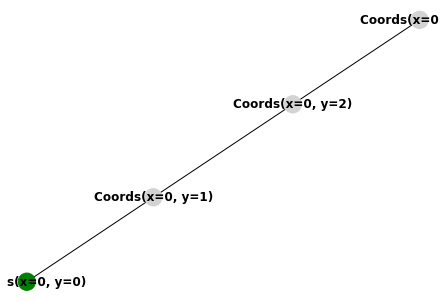

In [26]:
if __name__ == '__main__':
    main()

In this assignment the agent tracks which coordinates it has stepped in. If the agent finds the gold we find the shortest path back to (0,0) using the networkx's built in method. We then take that path back home.

The graph shown at the end of the printout shows the path taken by the agent to find the gold. Green is the starting point and yellow is the location of the gold.